In [1]:
from torchvision.datasets import CIFAR100
from torchvision import transforms as tt
from torch import nn
# from torchsummary import summary
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, random_split
import torch
from matplotlib import pyplot as plt
from torch.cuda.amp import autocast, GradScaler


# torch.set_default_dtype(torch.float32)

In [2]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

transforms = tt.Compose(
    [
        tt.ToTensor(),
        tt.RandomCrop(32, padding=5, padding_mode='reflect'),
        tt.RandomHorizontalFlip(),
#         tt.RandomRotation(10),
        tt.Normalize(*stats, inplace=True)
    ]
)




try:
    raw_training_dataset = CIFAR100(root='.', train=True, download=False, transform=transforms)
    raw_testing_dataset = CIFAR100(root='.', train=False, download=False, transform=tt.ToTensor())
    print("Data sync successful")
except RuntimeError:
    raw_training_dataset = CIFAR100(root='.', train=True, download=True, transform=transforms)
    raw_testing_dataset = CIFAR100(root='.', train=False, download=True, transform=tt.ToTensor())
    print("Data sync unsuccessful. Downloaded the dataset.")


training_dataset, validation_dataset = random_split(raw_training_dataset, [45000, 5000])

train_dl = DataLoader(dataset=training_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
valid_dl = DataLoader(dataset=validation_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)
test_dl = DataLoader(dataset=raw_testing_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

100%|██████████| 169001437/169001437 [00:08<00:00, 20656462.97it/s]


Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified
Data sync unsuccessful. Downloaded the dataset.


In [3]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch_data in self.dl:
            torch.cuda.empty_cache()
            yield [t.to(self.device, non_blocking=True) for t in batch_data]

    def __len__(self):
        return len(self.dl)

In [4]:
class CIFAR100Network(nn.Module):
    def __init__(self):
        super(CIFAR100Network, self).__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2)
        )

        self.resBlock0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=512),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1024),
            nn.MaxPool2d(kernel_size=2)

        )

        self.resBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1024),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1024)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=2048),

            nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1024),
            nn.MaxPool2d(kernel_size=2)

        )

        self.resBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1024),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=1024),
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1024 * 4 * 4, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=1024, out_features=100)
        )

    def forward(self, x):
        x = self.layer0(x)
        x = x + self.resBlock0(x)
        x = self.layer1(x)
        x = x + self.resBlock1(x)
        x = self.layer2(x)
        x = x + self.resBlock2(x)
        x = self.fc_layer(x)
        return x

model = CIFAR100Network()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = model.to(device=device)
    

# summary(model, (3, 32, 32), batch_size=128)


In [5]:
MAX_LR = 2e-3
EPOCHS = 50

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=2e-4, weight_decay=.01)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=MAX_LR, epochs=EPOCHS, steps_per_epoch=len(train_dl))

In [6]:
@torch.no_grad
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    average_loss = total_loss / len(loader)
    return average_loss

@torch.no_grad
def accuracy(model, loader, device):
    model.eval()
    total_correct = 0
    total_datapoints = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == targets).sum().item()
        total_datapoints += len(targets)
    total_accuracy = total_correct / total_datapoints
    return total_accuracy


@torch.no_grad
def evaluate(model, loader, criterion, device):
    """
    This function evaluates loss and calculate accuracy same time
    """

    model.eval()
    total_loss = 0
    total_correct = 0
    total_datapoints = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == targets).sum().item()
        total_datapoints += len(targets)
        del inputs, targets, outputs, preds
        torch.cuda.empty_cache()

    average_loss = total_loss / len(loader)
    total_accuracy = total_correct / total_datapoints

    return average_loss, total_accuracy


In [8]:
evaluate(model, valid_dl, criterion, device)

(4.605329574682774, 0.009615384615384616)

In [7]:
def fit_network(model, epochs, train_dl, valid_dl, criterion, optimizer, scheduler, device):
    """
    This function trains a neural network and evaluates its performance on a validation set.

    Args:
        model (nn.Module): The neural network model to train.
        epochs (int): Number of epochs to train the model.
        train_dl (DataLoader): DataLoader for the training set.
        valid_dl (DataLoader): DataLoader for the validation set.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training the model.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        device (torch.device): Device to run the training on (CPU or GPU).

    Returns:
        tuple: Training history and validation history.
    """

    train_history = []
    valid_history = []

    for epoch in range(epochs):
        model.train()
        batch_loss = 0

        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            train_loss = criterion(outputs, targets)
            train_loss.backward()
            optimizer.step()

            batch_loss += train_loss.item()
            
            # Free memory
            del inputs, targets, outputs
            torch.cuda.empty_cache()

        train_loss = batch_loss / len(train_dl)
        train_history.append(train_loss)

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, valid_dl, criterion, device)
        valid_history.append((val_loss, val_acc))

        print(f"{epoch+1}/{epochs}: train_loss[{train_loss:.4f}] - val_loss[{val_loss:.4f}] - val_acc[{val_acc:.4f}]")

        scheduler.step()

    return train_history, valid_history


In [9]:
def plot_training_history(train_history, valid_history):
    epochs = len(train_history)
    train_losses = train_history
    val_losses = [x[0] for x in valid_history]
    val_accuracies = [x[1] for x in valid_history]

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

In [10]:
train_history, valid_history = fit_network(model, EPOCHS, train_dl, valid_dl, criterion, optimizer, scheduler, device)

1/50: train_loss[3.6816] - val_loss[3.2232] - val_acc[0.2214]
2/50: train_loss[2.9869] - val_loss[2.7112] - val_acc[0.3077]
3/50: train_loss[2.5744] - val_loss[2.4152] - val_acc[0.3742]
4/50: train_loss[2.2967] - val_loss[2.1809] - val_acc[0.4101]
5/50: train_loss[2.0874] - val_loss[2.0590] - val_acc[0.4439]
6/50: train_loss[1.9219] - val_loss[1.9515] - val_acc[0.4772]
7/50: train_loss[1.7962] - val_loss[1.8160] - val_acc[0.5030]
8/50: train_loss[1.6890] - val_loss[1.7674] - val_acc[0.5196]
9/50: train_loss[1.5920] - val_loss[1.7050] - val_acc[0.5341]
10/50: train_loss[1.5113] - val_loss[1.6382] - val_acc[0.5457]
11/50: train_loss[1.4402] - val_loss[1.6308] - val_acc[0.5553]
12/50: train_loss[1.3685] - val_loss[1.6070] - val_acc[0.5605]
13/50: train_loss[1.3177] - val_loss[1.5346] - val_acc[0.5809]
14/50: train_loss[1.2646] - val_loss[1.4805] - val_acc[0.5935]
15/50: train_loss[1.2045] - val_loss[1.5105] - val_acc[0.5799]
16/50: train_loss[1.1630] - val_loss[1.4533] - val_acc[0.5992]
1

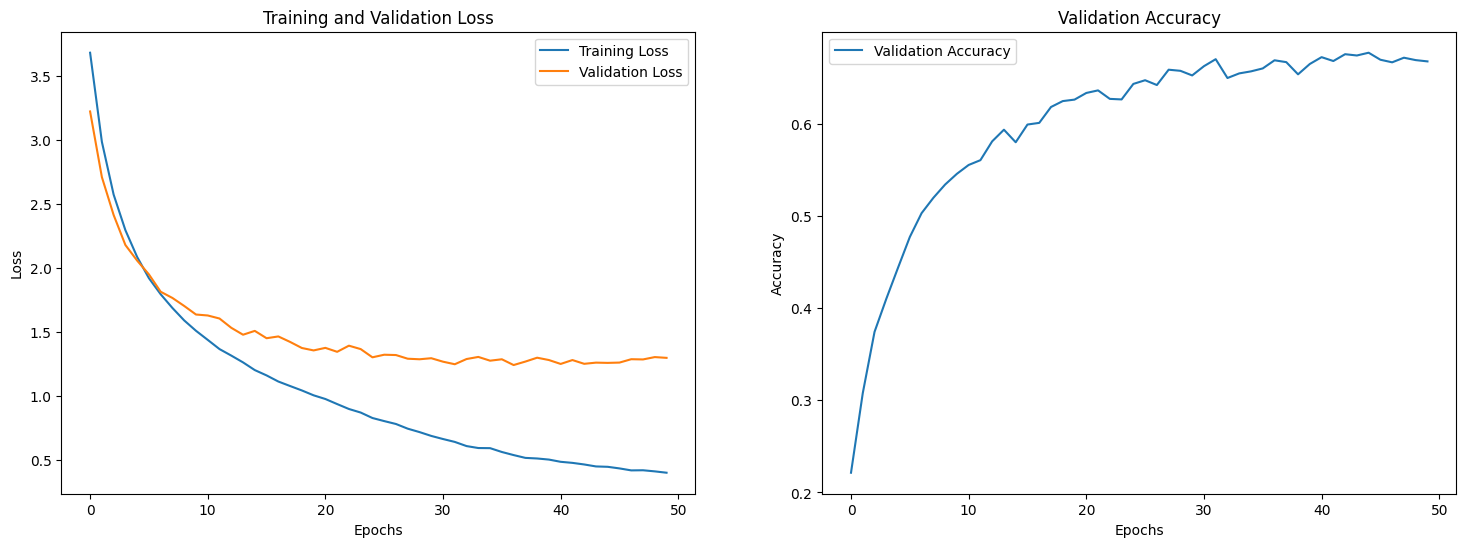

In [11]:
plot_training_history(train_history, valid_history)

In [13]:
torch.save(model.state_dict(), "cifar100-parameter.pth")